In [1]:
from statistics import mode
import numpy as np
from time import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import random
plt.rcdefaults()
from IPython.display import display, HTML
from itertools import chain
from sklearn.metrics import confusion_matrix
import seaborn as sb
import tensorflow as tf
from collections import Counter

### Loading the dataset

We are loading the Mnist dataset from the keras library

In [2]:
(a, b), (c, d) = tf.keras.datasets.mnist.load_data()
assert a.shape == (60000, 28, 28)
assert c.shape == (10000, 28, 28)
assert b.shape == (60000,)
assert d.shape == (10000,)

In [3]:
# we want our data points to be flattened as it will help in our computation
a = a.reshape((a.shape[0], -1))
c = c.reshape((c.shape[0], -1))
assert a.shape == (60000, 784)
assert c.shape == (10000, 784)

##### To reduce computation time, we are going to take only a small subset of the entire data available in the train and test set

In [4]:
np.random.seed(42) #setting the seed to reproduce the results

# performing a random sampling of images available to us
num_samples = 6000
random_indices = np.random.choice(len(a), size=num_samples, replace=False) # Generate random indices

# Select the corresponding subset from the features and labels
x_train = a[random_indices]
y_train = b[random_indices]

# similarly for the test set
num_samples = 3000
random_indices = np.random.choice(len(c), size=num_samples, replace=False)
x_test = c[random_indices]
y_test = d[random_indices]

In [5]:
print(f"The shape of x_train: {x_train.shape}")
print(f"The shape of y_train: {y_train.shape}")
print(f"The shape of x_test: {x_test.shape}")
print(f"The shape of y_test: {y_test.shape}")

The shape of x_train: (6000, 784)
The shape of y_train: (6000,)
The shape of x_test: (3000, 784)
The shape of y_test: (3000,)


##### View a few images to make sure labels are correct

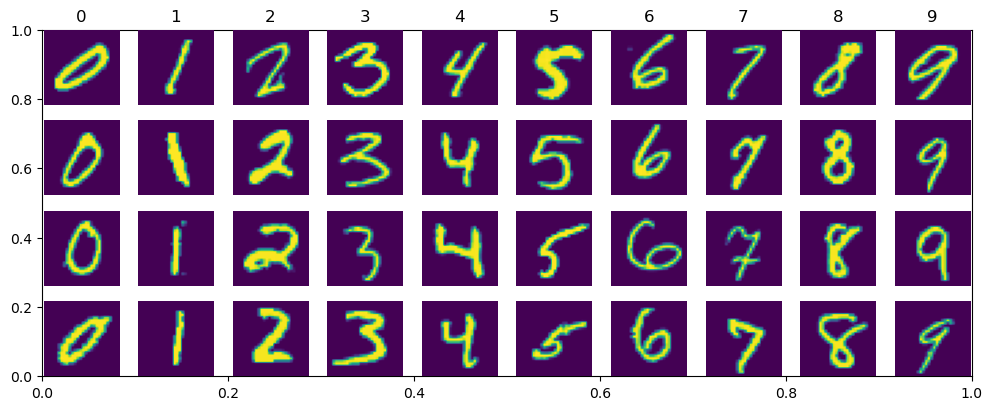

In [6]:
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
num_classes = len(classes)
samples = 4

plt.subplots(figsize=(12, 4.5))
for y, cls in enumerate(classes):
    idxs = np.nonzero([i == y for i in y_train])
    idxs = np.random.choice(idxs[0], samples, replace=False)
    for i , idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples, num_classes, plt_idx)
        plt.imshow(x_train[idx].reshape((28, 28)))
        plt.axis("off")
        if i == 0:
            plt.title(cls)
        

plt.show()

In [7]:
temp1 = dict(Counter(y_train))
for i,k in temp1.items():
    print(f"There are {k} data points of class {i}")

There are 633 data points of class 7
There are 589 data points of class 3
There are 585 data points of class 8
There are 632 data points of class 9
There are 551 data points of class 5
There are 580 data points of class 4
There are 572 data points of class 2
There are 580 data points of class 6
There are 654 data points of class 1
There are 624 data points of class 0


There is a fairly decent class balance in the training set so we wont focus on that

### Defining Naive Bayes and Error rate functions

In [15]:
def naivebayes(train, train_lb, test, test_lb, smoothing):
        n_class = np.unique(train_lb) # gets a list of all unique labels in training lable data
        tr = train
        te = test
        tr_lb = train_lb
        te_lb = test_lb
        smoothing = smoothing
        st = time()
        mean, std, prior, count = [], [], [], []
        for i, val in enumerate(n_class):
            sep = [tr_lb == val][0] # sep is a list of boolean values. True where condition is satisfied and false otherwise
            count.append(len(tr_lb[sep])) # counting the number of instances of a particular class
            prior.append(len(tr_lb[sep]) / len(tr_lb)) # calculating the prior(p[y=i]) as a frequency of occurence of the particular class in data 
            mean.append(np.mean(tr[sep], axis=0)) # calculating the mean values of the input data wherever the corresponding class label is i
            std.append(np.std(tr[sep], axis=0)) # calculating the standard deviation values of the input data wherever the corresponding class label is i
        
        pred = []
        likelihood = []
        lcs = []
        for n in range(len(te_lb)): # iterating through the length of test labels
            classifier = []
            sample = te[n] # taking a sample of the test data which keeps growing in size with every iteration
            ll = []
            for i, val in enumerate(n_class): # iterating through all the unique class labels
                m1 = mean[i]
                var = np.square(std[i]) + smoothing
                # assuming the probability distribution of p[x/y=i] to be normal we calculate the likelihood from the pdf of normal
                prob = 1 / np.sqrt(2 * np.pi * var) * np.exp(-np.square(sample - m1)/(2 * var))
                result = np.sum(np.log(prob))
                classifier.append(result)
                ll.append(prob)

            pred.append(np.argmax(classifier))
            likelihood.append(ll)
            lcs.append(classifier)
        
        return pred, likelihood

In [16]:
def error_rate(confusion_matrix):
    a = confusion_matrix
    b = a.sum(axis=1)
    df = []
    for i in range(0,10):
        temp = 1-a[i][i]/b[i]
        df.append(temp)
    
    df = pd.DataFrame(df)
    df.columns = ['% Error rate']
    return df*100

In [17]:
nb = naivebayes(train=x_train, train_lb=y_train, test=x_test, test_lb=y_test, smoothing=1000)
nb_pred = nb[0]

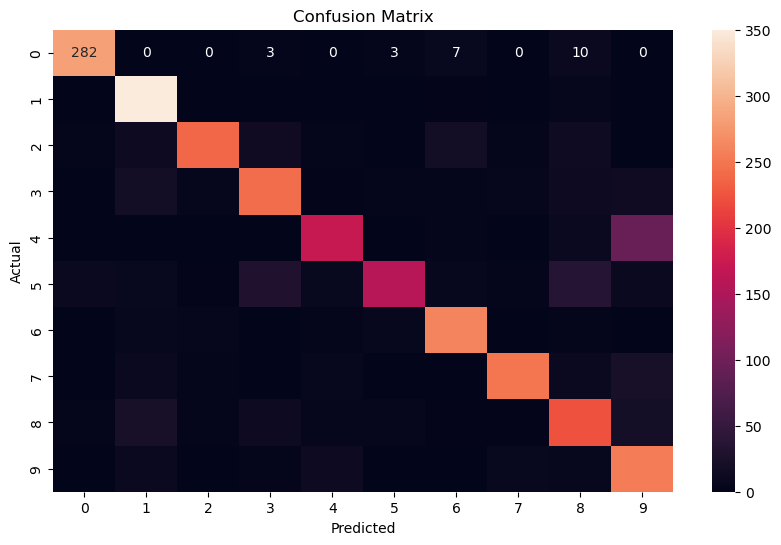

In [18]:
cm = confusion_matrix(y_test, nb_pred)
#cm # X-axis Predicted vs Y-axis Actual Values
plt.subplots(figsize=(10, 6))
sb.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [19]:
print("Test Accuracy:", round((sum(np.diagonal(cm)) / len(nb_pred)) * 100, 4), '%')

Test Accuracy: 81.1 %


In [20]:
error_rate(cm)

,% Error rate
0,7.540984
1,1.960784
2,21.710526
3,20.065789
4,38.790036
5,41.044776
6,8.741259
7,16.943522
8,25.333333
9,13.265306


##### Lets look at some of the misclassified examples

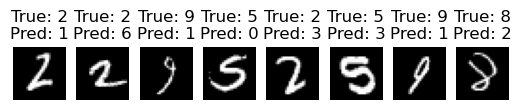

In [21]:
incorrect_indices = np.where(nb_pred != y_test)[0]

# Display some of the incorrect predictions
num_samples_to_display = 8

for i in range(num_samples_to_display):
    index = incorrect_indices[i]
    image = x_test[index].reshape(28, 28)  # Reshape to the original image size
    true_label = y_test[index]
    predicted_label = nb_pred[index]

    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'True: {true_label}\nPred: {predicted_label}')
    plt.axis('off')

plt.show()

### Results

We can see that the naive bayes has a lower accuracy compared to the KNN algorithm for the same task. this can be due to a few reasons:

1. Naive Bayes makes a couple of assumptions which arent made by KNN.
   * Assumes conditional independence of the features given the class labels.
   * Assumes that the likelihood distribution (of the features given the class labels) follows some parametric form - which was guassian in this case.
2. Naive Bayes also assumes linear relationship between the features and labels and isn't able to model non linearity, so if the underlying data points
   are non linear then Naive Bayes might not fare well.